## You can put your name here

* Name: Karthik Ragunath Ananda Kumar
* Net ID: KXA200005

Problem Set 4

CS 6375

Due: 4/21/2022 by 11:59pm

Note: all answers should be accompanied by explanations and relevant code for full credit. All
code (Python or MATLAB only) should be turned in with your answers to the following questions. Python is preferred.  
Late homeworks will not be accepted. 

The following code help you download the data files needed for the problems below. After running code, these files will appear in the current folder.

In [ ]:
# Downloading data files for you.
# Remember to run this cell!!

!wget -nc https://personal.utdallas.edu/~yangxiao.lu/22SP_CS6375/leaf.data
!wget -nc https://personal.utdallas.edu/~yangxiao.lu/22SP_CS6375/prostate_GE.data

--2022-04-28 23:33:14--  https://personal.utdallas.edu/~yangxiao.lu/22SP_CS6375/leaf.data
Resolving personal.utdallas.edu (personal.utdallas.edu)... 129.110.46.112
Connecting to personal.utdallas.edu (personal.utdallas.edu)|129.110.46.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40642 (40K)
Saving to: ‘leaf.data’

leaf.data           100%[===================>]  39.69K   246KB/s    in 0.2s    

2022-04-28 23:33:15 (246 KB/s) - ‘leaf.data’ saved [40642/40642]

--2022-04-28 23:33:16--  https://personal.utdallas.edu/~yangxiao.lu/22SP_CS6375/prostate_GE.data
Resolving personal.utdallas.edu (personal.utdallas.edu)... 129.110.46.112
Connecting to personal.utdallas.edu (personal.utdallas.edu)|129.110.46.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5294688 (5.0M)
Saving to: ‘prostate_GE.data’

prostate_GE.data    100%[===================>]   5.05M   839KB/s    in 7.0s    

2022-04-28 23:33:25 (735 KB/s) - ‘prostate_GE.data’ saved



---



---


#$\color{blue}{\text{Problem 1:}} \text{ PCA and Feature Selection} \color{red}{\text{(50 pts)}}$#

In this problem, we will explore ways that we can use PCA for the problem of generating or selecting "good" features.

In [ ]:
import numpy as np
from copy import deepcopy
from collections import defaultdict
import pandas as pd
import numpy as np
import cvxopt as cvxopt
from cvxopt import matrix, solvers
from numpy import linalg as LA

In [ ]:
def normalize_with_zero_mean_unit_variance(X):    
    M,N = X.shape    
    X_mean = X.sum(axis=0)/M
    X_sd = np.sqrt(((X - X_mean)**2).sum(axis=0)/M)
    X_sd[X_sd == 0] = 1
    res = ((X - X_mean) / X_sd)
    return np.nan_to_num(res, False, 1.0), X_mean, X_sd

def normalize(X):    
    M,N = X.shape    
    X_mean = X.sum(axis=0)/M
    X_sd = np.sqrt(((X - X_mean)**2).sum(axis=0)/M)
    X_sd[X_sd == 0] = 1
    res = (X - X_mean)
    return np.nan_to_num(res, False, 1.0), X_mean, X_sd

def rescale_with_zero_mean_unit_variance(X, X_mean, X_sd):
    X_mean = np.nan_to_num(X_mean, copy=False, nan=1.0, posinf=1, neginf=1)
    X_sd = np.nan_to_num(X_sd, copy=False, nan=1.0, posinf=1, neginf=1)
    X_sd[X_sd == 0] = 1
    res = ((X - X_mean) / X_sd)
    return np.nan_to_num(res, False, 1.0)
    
def rescale(X, X_mean, X_sd):
    X_mean = np.nan_to_num(X_mean, copy=False, nan=1.0, posinf=1, neginf=1)
    X_sd = np.nan_to_num(X_sd, copy=False, nan=1.0, posinf=1, neginf=1)
    X_sd[X_sd == 0] = 1
    res = (X - X_mean)
    return np.nan_to_num(res, False, 1.0)

def normalize_with_unit_magnitude(X):
    X = X / LA.norm(X, axis=0)
    return X

##1.1 SVMs and PCA (25 pts)


Consider the prostate GE data set (attached to this problem set). Each row corresponds to a single
data point and the final column in each row is the class label (1 or 2 here). You should use the
first 80 data points for training and the remaining 10% for testing.

* Perform PCA on the training data to reduce the dimensionality of the data set (ignoring the
class labels for the moment). What are the top six eigenvalues of the data covariance matrix?
Looking at the eigenvalues, how would you recommend picking k for this data set?


In [ ]:
prostate_ge_data = np.genfromtxt('./prostate_GE.data',delimiter=',')
prostate_ge_training = prostate_ge_data[:80, 1:]
prostate_ge_y_training = prostate_ge_data[:80, 0]
Y_train = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_training)))
prostate_ge_testing = prostate_ge_data[80:, 1:]
prostate_ge_y_testing = prostate_ge_data[80:, 0]
Y_test = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_testing)))

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

prostate_ge_training, train_mean, train_sd = normalize(prostate_ge_training)
prostate_ge_testing = rescale(prostate_ge_testing, train_mean, train_sd)

prostate_ge_training = prostate_ge_training.T
prostate_ge_testing = prostate_ge_testing.T
xT_x = np.matmul(prostate_ge_training.T, prostate_ge_training)

eigen_weights, eigen_vectors = LA.eig(xT_x)
sorted_indices = eigen_weights.argsort()[::-1]
sorted_eigen_weights = eigen_weights[sorted_indices]

total_weight = 0
for index, eigen_weight in enumerate(sorted_eigen_weights):
    total_weight += eigen_weight

cumulative_percentage = 0
cumulative_weight = 0
optimal_k = None
for index, eigen_weight in enumerate(sorted_eigen_weights):
    cumulative_weight += eigen_weight
    cumulative_percentage = (cumulative_weight) / total_weight
    if cumulative_percentage >= 0.9:
        optimal_k = index + 1
        break

In [ ]:
optimal_k

34

K Value of 34 is reasonanble since it captures 90% of the variance in the data





---



---


# * For each k ∈ {1, 2, 3, 4, 5, 6}, project the training data into the best k dimensional subspace (with respect to the Frobenius norm) and use the SVM with slack formulation to learn a classifier for each c ∈ {1, 10, 100, 1000}. As data is limited, this process should be done with 10-fold cross-validation. Report the average error of the learned classifier on the held out validation data for each k and c pair.

In [ ]:
# To be completed. Please write code or words below the problem.
solvers.options['show_progress'] = False
def quad_solver(X=None, Y=None, c_value=None):
    n = X.shape[0]
    H = np.multiply(np.matmul(Y, Y.T), np.matmul(X, X.T))
    q = np.repeat([-1.0], n)
    A = Y.reshape(1, -1)
    b = np.zeros(1)
    G = np.vstack((np.negative(np.eye(n)), np.eye(n)))
    h = np.hstack((np.zeros(n), np.ones(n) * c_value))

    A = A.astype('float')
    H = H.astype('float')
    P = matrix(H)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)
    A = matrix(A)
    b = matrix(b)
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol["x"])
    optimal_w = np.dot((Y * alphas).T, X)[0]
    
    optimal_w_reshaped = optimal_w.reshape(-1, 1)
    S = np.where((alphas > 1e-4) & (alphas < c_value))[0]
    bias = (Y[S] - np.dot(X[S], optimal_w_reshaped))[0]
    return optimal_w, bias

In [ ]:
def check_convergence(W, X, b, Y, M):
    check_classifications = np.multiply(Y, np.add(np.sum(np.multiply(W, X), axis = 1).reshape(-1, 1), b)).reshape(M,)
    valid = 0
    for i in range(M):
        if check_classifications[i] > 0:
            valid += 1
    return (valid / M)

In [ ]:
def cross_validation(data, num_cross_valid, K, c):
    k_split_len = len(data) // num_cross_valid
    accuracy_list = []
    for i in range(num_cross_valid):
        left_index = i * k_split_len
        middle_index = left_index + k_split_len
        split_array = np.split(data, [left_index, middle_index, len(data)])
        train = np.concatenate((split_array[0], split_array[2]), axis=0)
        valid = split_array[1]

        Y = train[:,0]
        Y = np.array(list(map(lambda x: 1 if x == 1 else -1, Y)))
        X = train[:,1:]
        K = K if K <= X.shape[1] else X.shape[1]
        X = X[:, :K].reshape(-1, K)
        Y = Y.reshape(-1,1)

        Y_valid = valid[:,0]
        Y_valid = np.array(list(map(lambda x: 1 if x == 1 else -1, Y_valid)))
        X_valid = valid[:,1:]
        X_valid = X_valid[:, :K].reshape(-1, K)
        Y_valid = Y_valid.reshape(-1,1)
        optimal_weights, bias = quad_solver(X=X, Y=Y, c_value=c)

        WX = np.sum(np.multiply(optimal_weights, X_valid), axis=1)
        linear_sum = WX + bias
        correct_val = 0
        num_samples = len(valid)
        for i in range(num_samples):
          if (Y_valid[i] * linear_sum[i]) >= 0:
            correct_val += 1
        accuracy_list.append((correct_val / num_samples))
    accuracy = np.mean(accuracy_list)
    return accuracy

In [ ]:
from collections import defaultdict
cross_valid_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

prostate_ge_data = np.genfromtxt('./prostate_GE.data',delimiter=',')
prostate_ge_training = prostate_ge_data[:80, 1:]
prostate_ge_y_training = prostate_ge_data[:80, 0]
Y_train = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_training)))
prostate_ge_testing = prostate_ge_data[80:, 1:]
prostate_ge_y_testing = prostate_ge_data[80:, 0]
Y_test = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_testing)))

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

prostate_ge_training, train_mean, train_sd = normalize(prostate_ge_training)
prostate_ge_testing = rescale(prostate_ge_testing, train_mean, train_sd)

prostate_ge_training = prostate_ge_training.T
prostate_ge_testing = prostate_ge_testing.T
xT_x = np.matmul(prostate_ge_training.T, prostate_ge_training)

k = 6
w_row, v_row = LA.eig(xT_x)
idx = w_row.argsort()[::-1][0:k]
eigen_vectors = v_row[:, idx]
eigen_weights = w_row[idx]
rescaled_eigen_vectors = np.matmul(prostate_ge_training, eigen_vectors)
rescaled_eigen_vectors = normalize_with_unit_magnitude(rescaled_eigen_vectors)

projection_matrix = np.matmul(prostate_ge_training.T, rescaled_eigen_vectors)
combined_data = np.hstack((Y_train, projection_matrix))

projection_matrix_test = np.matmul(prostate_ge_testing.T, rescaled_eigen_vectors)
combined_data_test = np.hstack((Y_test, projection_matrix_test))

for k in [1,2,3,4,5,6]:
    for c in [1, 10, 100, 1000]:
        accuracy = cross_validation(combined_data, 10, k, c)
        cross_valid_dict[k][c]['average_accuracy'] = accuracy
        cross_valid_dict[k][c]['average_error'] = 1 - accuracy

In [ ]:
cross_valid_dict

defaultdict(<function __main__.<lambda>>,
            {1: defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {1: defaultdict(list,
                                      {'average_accuracy': 0.825,
                                       'average_error': 0.17500000000000004}),
                          10: defaultdict(list,
                                      {'average_accuracy': 0.825,
                                       'average_error': 0.17500000000000004}),
                          100: defaultdict(list,
                                      {'average_accuracy': 0.825,
                                       'average_error': 0.17500000000000004}),
                          1000: defaultdict(list,
                                      {'average_accuracy': 0.8,
                                       'average_error': 0.19999999999999996})}),
             2: defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {1: def

The average error of the learned classifier on the held out validation data for each k and c pair

In [ ]:
for k, k_dict in cross_valid_dict.items():
    for c, c_dict in k_dict.items():
        print("k:", k, "- c:", c, "- Average Error Percentage:", c_dict['average_error']*100, "%")

k: 1 - c: 1 - Average Error Percentage: 17.500000000000004 %
k: 1 - c: 10 - Average Error Percentage: 17.500000000000004 %
k: 1 - c: 100 - Average Error Percentage: 17.500000000000004 %
k: 1 - c: 1000 - Average Error Percentage: 19.999999999999996 %
k: 2 - c: 1 - Average Error Percentage: 18.75 %
k: 2 - c: 10 - Average Error Percentage: 18.75 %
k: 2 - c: 100 - Average Error Percentage: 18.75 %
k: 2 - c: 1000 - Average Error Percentage: 18.75 %
k: 3 - c: 1 - Average Error Percentage: 22.499999999999996 %
k: 3 - c: 10 - Average Error Percentage: 22.499999999999996 %
k: 3 - c: 100 - Average Error Percentage: 22.499999999999996 %
k: 3 - c: 1000 - Average Error Percentage: 17.500000000000004 %
k: 4 - c: 1 - Average Error Percentage: 22.499999999999996 %
k: 4 - c: 10 - Average Error Percentage: 22.499999999999996 %
k: 4 - c: 100 - Average Error Percentage: 22.499999999999996 %
k: 4 - c: 1000 - Average Error Percentage: 22.499999999999996 %
k: 5 - c: 1 - Average Error Percentage: 9.9999999999



---



---


## *** What is the performance you achieve on the test set via the proper hyperparameter selection procedure above?**

In [ ]:
best_k = None
best_c = None
best_accuracy = 0
for k, k_dict in cross_valid_dict.items():
    for c, c_dict in k_dict.items():
        accuracy = c_dict['average_accuracy']
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
            best_c = c

Best K and Best C of the Learned Classifer

In [ ]:
print("Best K:", best_k)
print("Best C:", best_c)

Best K: 5
Best C: 1


In [ ]:
def test_hyperparam(k=None, c=None, train=None, test=None):
    Y = train[:,0]
    Y = np.array(list(map(lambda x: 1 if x == 1 else -1, Y)))
    X = train[:,1:]
    X = X[:, :k].reshape(-1, k)
    Y = Y.reshape(-1,1)
    optimal_weights, bias = quad_solver(X=X, Y=Y, c_value=c)

    Y_test = test[:,0]
    Y_test = np.array(list(map(lambda x: 1 if x == 1 else -1, Y_test)))
    X_test = test[:,1:]
    X_test = X_test[:, :k].reshape(-1, k)
    Y_test = Y_test.reshape(-1,1)

    WX = np.sum(np.multiply(optimal_weights, X_test), axis=1)
    linear_sum = WX + bias
    correct_val = 0
    num_samples = len(test)
    for i in range(num_samples):
        if (Y_test[i] * linear_sum[i]) >= 0:
            correct_val += 1
    accuracy = (correct_val / num_samples)
    return optimal_weights, bias, accuracy, linear_sum

In [ ]:
optimal_weights, bias, accuracy, linear_sum = test_hyperparam(k=best_k, c=best_c, train=combined_data, test=combined_data_test)

In [ ]:
print("Optimal Accuracy:", accuracy)

Optimal Accuracy: 0.9545454545454546


In [ ]:
print("Optimal Weight:", optimal_weights)
print("Optimal Bias:", bias)

Optimal Weight: [-0.17636923 -0.21572036  0.1021559   0.17886339 -0.25915385]
Optimal Bias: [-0.12301897]



---

# * Now suppose that we don’t do proper hyperparameter selection. What is the best performance that you can achieve on the test set if you tune the hyperparameters using the test set instead of the validation set?

In [ ]:
test_set_hyper_param_tuning = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for k in [1,2,3,4,5,6]:
    for c in [1, 10, 100, 1000]:
        optimal_weights, bias, accuracy, linear_sum = test_hyperparam(k=k, c=c, train=combined_data, test=combined_data_test)
        test_set_hyper_param_tuning[k][c]['accuracy'] = accuracy
        test_set_hyper_param_tuning[k][c]['bias'] = bias
        test_set_hyper_param_tuning[k][c]['weights'] = optimal_weights

In [ ]:
test_set_hyper_param_tuning

defaultdict(<function __main__.<lambda>>,
            {1: defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {1: defaultdict(list,
                                      {'accuracy': 0.9090909090909091,
                                       'bias': array([1.06702986]),
                                       'weights': array([-0.14705363])}),
                          10: defaultdict(list,
                                      {'accuracy': 0.9090909090909091,
                                       'bias': array([1.06702988]),
                                       'weights': array([-0.14705367])}),
                          100: defaultdict(list,
                                      {'accuracy': 0.9090909090909091,
                                       'bias': array([1.06702986]),
                                       'weights': array([-0.14705363])}),
                          1000: defaultdict(list,
                                      {'accuracy'

In [ ]:
best_accuracy = 0
best_k = None
best_c = None
for k, k_dict in test_set_hyper_param_tuning.items():
    for c, c_dict in k_dict.items():
        accuracy = c_dict['accuracy']
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
            best_c = c

In [ ]:
print("Best Accuracy:", best_accuracy)
print("Best K:", best_k)
print("Best C:", best_c)

Best Accuracy: 0.9545454545454546
Best K: 2
Best C: 1




---



---


## 1.2 PCA for Feature Selection (25 pts)

If we performed PCA directly on the training data as we did in the first part of this question, we
would generate new features that are linear combinations of our original features. If instead, we
wanted to find a subset of our current features that were good for classification, we could still use
PCA, but we would need to be more clever about it. The primary idea in this approach is to select features from the data that are good at explaining as much of the variance as possible. To do this,
we can use the results of PCA as a guide. Implement the following algorithm for a given k and s:
1.   Compute the top $k$ eigenvalues and eigenvector of the covariance matrix corresponding to the data matrix omitting the labels (recall that the columns of the data matrix are the input data points). Denote the top $k$ eigenvectors as $v^{(1)}, ... , v^{(k)}$.

In [ ]:
prostate_ge_data = np.genfromtxt('./prostate_GE.data',delimiter=',')
prostate_ge_training = prostate_ge_data[:80, 1:]
prostate_ge_y_training = prostate_ge_data[:80, 0]
Y_train = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_training)))
prostate_ge_testing = prostate_ge_data[80:, 1:]
prostate_ge_y_testing = prostate_ge_data[80:, 0]
Y_test = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_testing)))

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

prostate_ge_training, train_mean, train_sd = normalize(prostate_ge_training)
prostate_ge_testing = rescale(prostate_ge_testing, train_mean, train_sd)

prostate_ge_training = prostate_ge_training.T
prostate_ge_testing = prostate_ge_testing.T
xT_x = np.matmul(prostate_ge_training.T, prostate_ge_training)

w_row, v_row = LA.eig(xT_x)
k_list = [1,10,20,40,80,160]
idx = w_row.argsort()[::-1]
sorted_eigen_vectors = v_row[:, idx]
sorted_eigen_weights = w_row[idx]
rescaled_sorted_eigen_vectors = np.matmul(prostate_ge_training, sorted_eigen_vectors)



---



---


2.   Define $\pi_j = \frac{1}{k}\sum_{i=1}^k v_j^{(i)^2}$.
3.   Sample $s$ features independently from the probability distribution defined by $\pi$.

In [ ]:
def discrete_random_sampling(distributions=None, apply_transform=False, num_samples=1, k=1):
    min_value = 0
    max_value = 0

    if apply_transform:
        transformed_distributions = distributions ** 2
    else:
        transformed_distributions = distributions
    transformed_distributions = (np.sum(transformed_distributions, axis=1)) / k
    sorted_transformed_distributions = np.argsort(transformed_distributions)[::-1]

    distance_pair = []
    for dist in transformed_distributions:
        distance_pair.append((max_value, max_value + dist))
        max_value = max_value + dist
        
    
    feature_set = set()
    while len(feature_set) < num_samples:
        random_point = np.random.uniform(low=min_value, high=max_value)
        low = 0
        high = len(distance_pair) - 1
        while low <= high:
            mid = (low + high) // 2
            if distance_pair[mid][0] <= random_point and distance_pair[mid][1] > random_point:
                break
            else:
                if distance_pair[mid][0] > random_point:
                    high = mid - 1
                elif distance_pair[mid][1] <= random_point:
                    low = mid + 1
        if mid not in feature_set:
            feature_set.add(mid)
    return feature_set



---



---


*  Why does $\pi$ define a probability distribution?

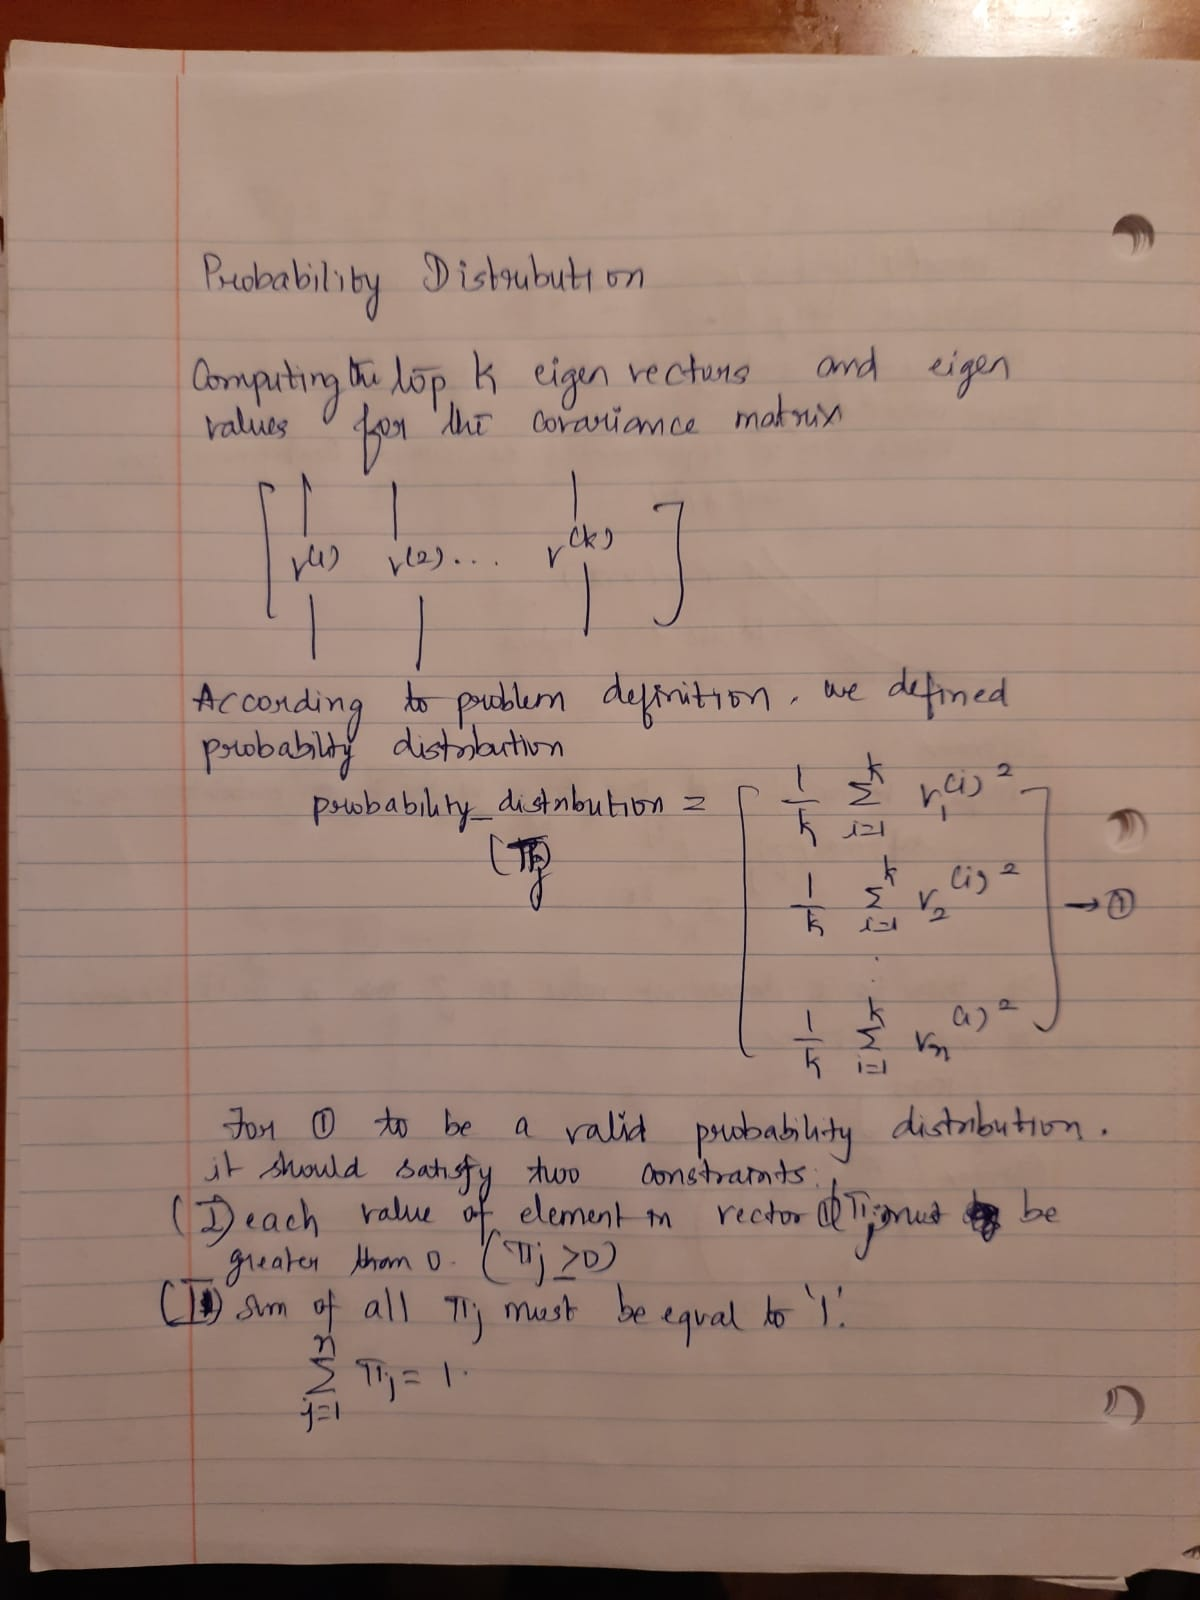

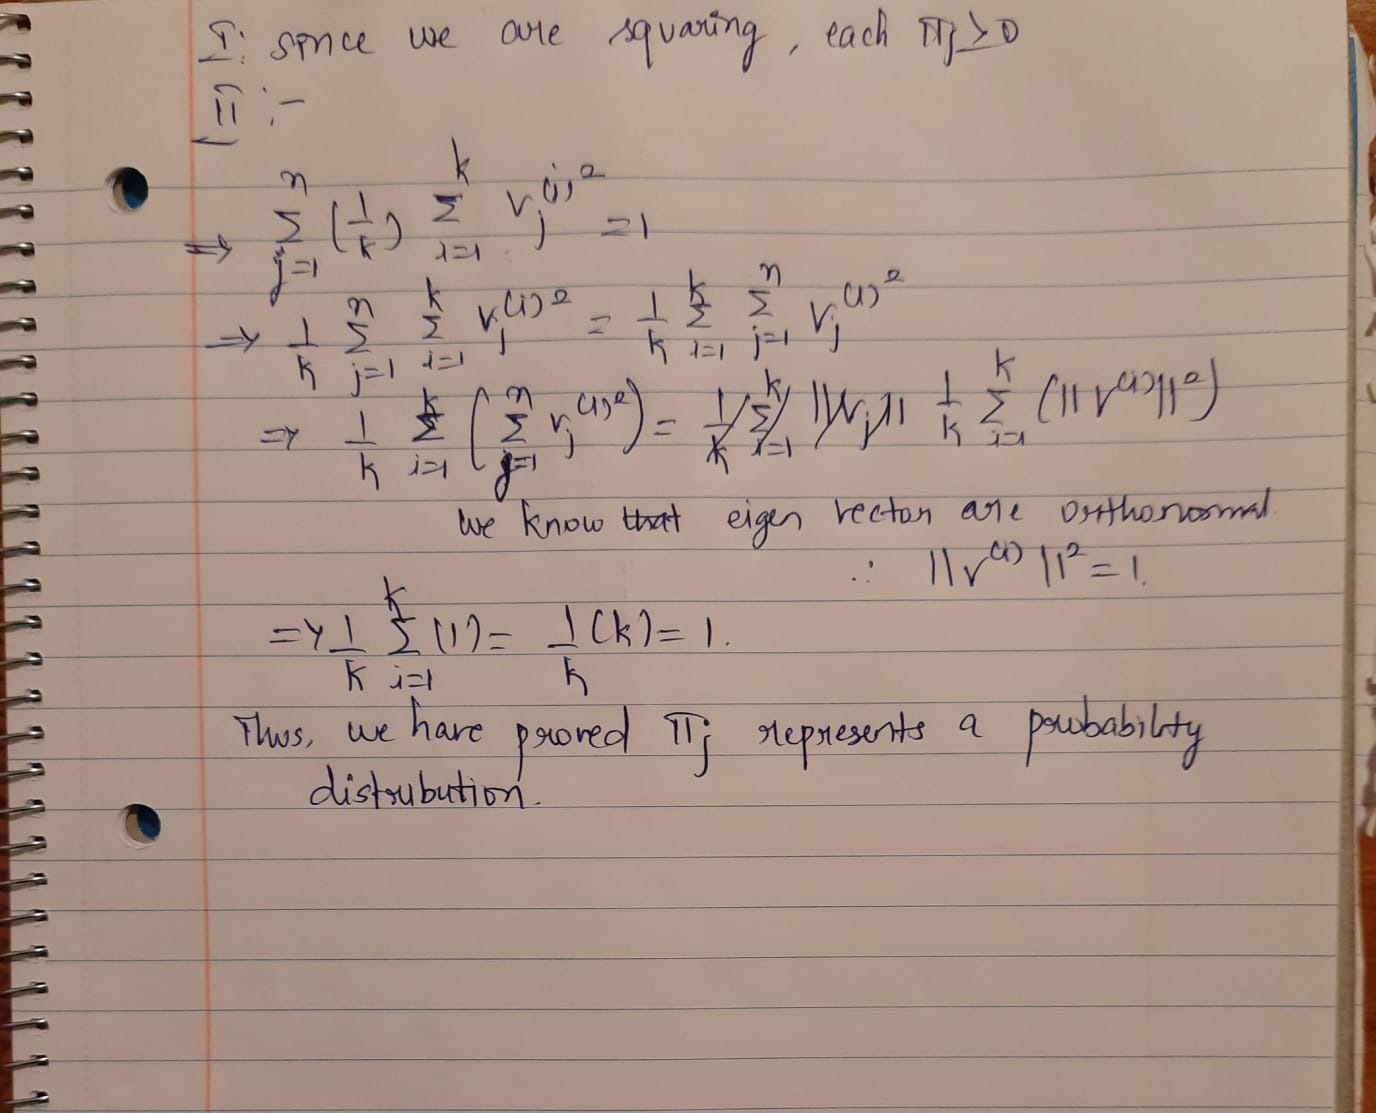



---



---


*  Again, using the prostate_GE data set and same procedure as above, for each $k\in\{1,10,20,40,80,160\}$ with $s=\lfloor k\log k\rfloor$, report the average test error of the SVM with slack classifier over $20$ experiments. For each experiment use only the $s$ selected features (note that there may be some duplicates, so only include each feature once). Use the same hyperparameter search for $c$ as in part 1.

In [ ]:
cross_validation_experiments = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
for k in [1, 10, 20, 40, 80, 160]:
    for c in [1, 10, 100, 1000]:
        for exp in range(20):
            eigen_vectors = rescaled_sorted_eigen_vectors[:, :k]
            num_samples = int(k * np.log(k))
            feature_set = discrete_random_sampling(distributions=eigen_vectors, apply_transform=True, num_samples=num_samples, k=k)
            feature_list = list(feature_set)
            prostate_ge_data = np.genfromtxt('./prostate_GE.data',delimiter=',')
            prostate_ge_training = prostate_ge_data[:80, 1:]
            prostate_ge_training = prostate_ge_training[:, feature_list]
            prostate_ge_y_training = prostate_ge_data[:80, 0]
            Y_train = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_training)))
            prostate_ge_testing = prostate_ge_data[80:, 1:]
            prostate_ge_testing = prostate_ge_testing[:, feature_list]
            prostate_ge_y_testing = prostate_ge_data[80:, 0]
            Y_test = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_testing)))

            Y_train = Y_train.reshape(-1, 1)
            Y_test = Y_test.reshape(-1, 1)

            prostate_ge_training, train_mean, train_sd = normalize(prostate_ge_training)
            prostate_ge_testing = rescale(prostate_ge_testing, train_mean, train_sd)

            prostate_ge_training = prostate_ge_training.T
            prostate_ge_testing = prostate_ge_testing.T
            xT_x = np.matmul(prostate_ge_training.T, prostate_ge_training)

            w_row, v_row = LA.eig(xT_x)
            idx = w_row.argsort()[::-1][0:k]
            eigen_vectors = v_row[:, idx]
            eigen_weights = w_row[idx]
            rescaled_eigen_vectors = np.matmul(prostate_ge_training, eigen_vectors)
            rescaled_eigen_vectors = normalize_with_unit_magnitude(rescaled_eigen_vectors)
            projection_matrix = np.matmul(prostate_ge_training.T, rescaled_eigen_vectors)
            combined_data = np.hstack((Y_train, projection_matrix))

            projection_matrix_test = np.matmul(prostate_ge_testing.T, rescaled_eigen_vectors)
            combined_data_test = np.hstack((Y_test, projection_matrix_test))
            accuracy = cross_validation(combined_data, 10, k, c)
            cross_validation_experiments[k][c][exp]['accuracy'] = accuracy
            cross_validation_experiments[k][c][exp]['feature_list'] = feature_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


In [ ]:
cross_validation_experiments

defaultdict(<function __main__.<lambda>>,
            {1: defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {1: defaultdict(<function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>>,
                                      {0: defaultdict(list,
                                                   {'accuracy': 0.5125,
                                                    'feature_list': []}),
                                       1: defaultdict(list,
                                                   {'accuracy': 0.5125,
                                                    'feature_list': []}),
                                       2: defaultdict(list,
                                                   {'accuracy': 0.5125,
                                                    'feature_list': []}),
                                       3: defaultdict(list,
                                                   {'accuracy': 0.5125,
                         

In [ ]:
k_accuracy_dict = defaultdict(int)
k_average_test_error = defaultdict(int)
for k, k_dict in cross_validation_experiments.items():
    values = []
    for c, c_dict in k_dict.items():
        for exp, exp_dict in c_dict.items():
            values.append(exp_dict['accuracy'])
    average_val = np.mean(values)
    k_accuracy_dict[k] = average_val
    k_average_test_error[k] = 1 - average_val

# Average Accuracy Dictionary For Each Value Of K



In [ ]:
k_accuracy_dict

defaultdict(int,
            {1: 0.5125000000000001,
             10: 0.8181249999999999,
             20: 0.82109375,
             40: 0.8378125000000001,
             80: 0.8759375,
             160: 0.87859375})

# Average Test Error For Each Value Of K


In [ ]:
k_average_test_error

defaultdict(int,
            {1: 0.48749999999999993,
             10: 0.18187500000000012,
             20: 0.17890625000000004,
             40: 0.16218749999999993,
             80: 0.12406249999999996,
             160: 0.12140625000000005})

In [ ]:
best_accuracy = 0
best_k = None
best_c = None
best_experiment = None
best_features = None
for k, k_dict in cross_validation_experiments.items():
    for c, c_dict in k_dict.items():
        for exp, exp_dict in c_dict.items():
            accuracy = exp_dict['accuracy']
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_k = k
                best_c = c
                best_experiment = exp
                best_features = exp_dict['feature_list']

Best K, Best C

In [ ]:
print(best_k, best_c, best_experiment, best_features)

40 1 5 [3584, 5136, 528, 2066, 21, 3095, 5660, 1571, 1575, 4648, 4650, 5695, 1599, 1089, 4677, 5193, 2635, 3152, 4182, 602, 93, 605, 5729, 1127, 4200, 3687, 5744, 5745, 114, 4093, 4222, 5761, 133, 144, 5265, 3226, 163, 4265, 170, 4271, 3760, 4785, 5807, 2227, 3252, 5305, 2748, 189, 4796, 3779, 708, 1220, 1227, 4812, 2765, 1230, 4300, 3795, 4307, 5848, 3801, 218, 5852, 3296, 3808, 738, 742, 4335, 752, 1785, 2815, 261, 3334, 5388, 3853, 4367, 4887, 1821, 801, 1316, 4392, 297, 2859, 1840, 5425, 3890, 2355, 820, 2866, 304, 4921, 3899, 3901, 4415, 2367, 323, 1861, 331, 3405, 4433, 1873, 4947, 3414, 860, 2914, 359, 5480, 4970, 4973, 1390, 4977, 1394, 3958, 378, 1917, 4989, 1918, 4481, 2947, 4484, 389, 3471, 5008, 4496, 4502, 923, 3488, 931, 4516, 5032, 5044, 4031, 447, 462, 4562, 4567, 3033, 2522, 2018, 491, 4079, 5112, 3067, 1532, 2045, 4606, 2559]


Testing with hyperparameters obtained from experiments conducted with restricted feature space

In [ ]:
prostate_ge_data = np.genfromtxt('./prostate_GE.data',delimiter=',')
prostate_ge_training = prostate_ge_data[:80, 1:]
prostate_ge_training = prostate_ge_training[:, best_features]
prostate_ge_y_training = prostate_ge_data[:80, 0]
Y_train = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_training)))
prostate_ge_testing = prostate_ge_data[80:, 1:]
prostate_ge_testing = prostate_ge_testing[:, best_features]
prostate_ge_y_testing = prostate_ge_data[80:, 0]
Y_test = np.array(list(map(lambda x: 1 if x == 1 else -1, prostate_ge_y_testing)))

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

prostate_ge_training, train_mean, train_sd = normalize(prostate_ge_training)
prostate_ge_testing = rescale(prostate_ge_testing, train_mean, train_sd)

prostate_ge_training = prostate_ge_training.T
prostate_ge_testing = prostate_ge_testing.T
xT_x = np.matmul(prostate_ge_training.T, prostate_ge_training)

k = best_k
w_row, v_row = LA.eig(xT_x)
idx = w_row.argsort()[::-1][0:k]
eigen_vectors = v_row[:, idx]
eigen_weights = w_row[idx]
rescaled_eigen_vectors = np.matmul(prostate_ge_training, eigen_vectors)
rescaled_eigen_vectors = normalize_with_unit_magnitude(rescaled_eigen_vectors)

projection_matrix = np.matmul(prostate_ge_training.T, rescaled_eigen_vectors)
combined_data = np.hstack((Y_train, projection_matrix))

projection_matrix_test = np.matmul(prostate_ge_testing.T, rescaled_eigen_vectors)
combined_data_test = np.hstack((Y_test, projection_matrix_test))

In [ ]:
optimal_weights, bias, accuracy, linear_sum = test_hyperparam(k=best_k, c=best_c, train=combined_data, test=combined_data_test)

In [ ]:
accuracy

0.9545454545454546

* Does this provide a reasonable alternative to the SVM with slack formulation without feature
selection on this data set? What are the pros and cons of this approach?

This seems to provide a reasonable alternative to the SVM with slack formulation without feature selection since we can clearly see that maximum accuracy which we get based on hyperparameter tuning on data with random feature selection is comparable to the maximum accuracy which we get without feature selection.

# Pros:

We can get comparable accuracy to the SVM with slack without feature selection with lesser number of features.

More control on regularization since we can tryout multiple combinations of features to be used for training the SVM.

# Cons:
Time taken for hyper-parameter tuning increases linearly with number of different combinations of features we are willing to experiment with.

The hyperparameter tuning is difficult since we randomly select features and hence we have to repeat for large number of iterations to be confident of the hyperaparameters we select.



---



---


#$\color{blue}{\text{Problem 2:}} \text{ Working with k-means} \color{red}{\text{(50 pts)}}$#

For this problem, you will use the leaf.data file provided with this problem set. This data set
was generated from the UCI Leaf Data Set (follow the link for information about the format of the
data). The class labels are still in the data set and should be used for evaluation only (i.e., don’t
use them in the clustering procedure), but the specimen number has been removed. You should
preprocess the data so that the non-label attributes have mean zero and variance one.

## 2.1 Train a k-means classifier for each $k\in\{10, 15, 20, 25, 30\}$ starting from twenty different random initializations (sample uniformly from $[−3, 3]$ for each attribute) for each $k$. Report the
mean and variance of the value of the $k$-means objective obtained for each $k$.

In [ ]:
def normalize(X):    
    M,N = X.shape    
    X_mean = X.sum(axis=0)/M
    X_sd = np.sqrt(((X - X_mean)**2).sum(axis=0)/M)
    res = ((X - X_mean) / X_sd)
    return np.nan_to_num(res, False, 1.0), X_mean, X_sd
    
def rescale(X, X_mean, X_sd):
    return (X - X_mean)/ X_sd

In [ ]:
def compute_new_centers(k, cluster_index_dict, X_norm):
    new_k_centers = []
    for cluster_index in range(k):
        sample_indices = cluster_index_dict[cluster_index]
        if len(sample_indices) != 0:
            samples_of_interest = X_norm[sample_indices]
            new_k_centers.append(samples_of_interest.sum(axis=0)/len(samples_of_interest))
        else:
            new_k_centers.append(np.zeros(X_norm.shape[1]))
    return new_k_centers

In [ ]:
def compute_cost(X_norm=None, cluster_index_dict=None, cluster_centers=None):
    distance_cost = 0
    for cluster_index, cluster_items in cluster_index_dict.items():
        for cluster_item in cluster_items:
            distance_cost += LA.norm(X_norm[cluster_item] - cluster_centers[cluster_index])
    return distance_cost

In [ ]:
def average_distance_metric(distance_metrics=None):
    average_distance_cost = defaultdict(int)
    for k, k_dict in distance_metrics.items():
        distance = 0
        for seed, distance_val in k_dict.items():
            distance += distance_val
        distance = distance / len(k_dict.keys())
        average_distance_cost[k] = distance
    return average_distance_cost

In [ ]:
def compare_dicts(cluster_index_dict=None, cluster_index_dict_copy=None):
    for key, val in cluster_index_dict.items():
        set_difference = set(val).difference(set(cluster_index_dict_copy[key]))
        if len(set_difference) != 0:
            return False
    for key, val in cluster_index_dict_copy.items():
        set_difference = set(val).difference(set(cluster_index_dict[key]))
        if len(set_difference) != 0:
            return False
    return True

In [ ]:
leaf_data = np.genfromtxt('./leaf.data',delimiter=',')
Y = leaf_data[:, 0]
X = leaf_data[:, 1:]
X_norm, X_mean, X_std = normalize(X)
clutser_centers = defaultdict(lambda: defaultdict(list))
distance_metrics = defaultdict(lambda: defaultdict(int))
for k in [10,15,20,25,30]:
    for random_seed in range(20):
        np.random.seed(random_seed)
        k_centers = np.random.uniform(low=-3, high=3, size=(k, X_norm.shape[1]))
        epoch = 0
        while True and epoch < 1000:
            if epoch != 0:
                cluster_index_dict_copy = deepcopy(cluster_index_dict)
            else:
                cluster_index_dict_copy = defaultdict(list)            
            cluster_index_dict = defaultdict(list)
            for sample_index in range(X_norm.shape[0]):
                min_distance = np.inf
                for center_index, k_center in enumerate(k_centers):
                    distance = LA.norm(X_norm[sample_index] - k_center)
                    if distance < min_distance:
                        min_distance = distance
                        cluster_index = center_index
                cluster_index_dict[cluster_index].append(sample_index)
            is_same = compare_dicts(cluster_index_dict=cluster_index_dict, cluster_index_dict_copy=cluster_index_dict_copy)
            if is_same:
                print('#'*10, "Converged: Seed:", random_seed, "K:", k, "Epochs:", epoch, '#'*10)
                clutser_centers[k][random_seed] = k_centers
                distance_cost = compute_cost(X_norm=X_norm, cluster_index_dict=cluster_index_dict, cluster_centers=k_centers)
                distance_metrics[k][random_seed] = distance_cost
                break
            new_centers = compute_new_centers(k, cluster_index_dict, X_norm)
            k_centers = new_centers
            epoch += 1

########## Converged: Seed: 0 K: 10 Epochs: 18 ##########
########## Converged: Seed: 1 K: 10 Epochs: 10 ##########
########## Converged: Seed: 2 K: 10 Epochs: 14 ##########
########## Converged: Seed: 3 K: 10 Epochs: 18 ##########
########## Converged: Seed: 4 K: 10 Epochs: 9 ##########
########## Converged: Seed: 5 K: 10 Epochs: 12 ##########
########## Converged: Seed: 6 K: 10 Epochs: 12 ##########
########## Converged: Seed: 7 K: 10 Epochs: 28 ##########
########## Converged: Seed: 8 K: 10 Epochs: 29 ##########
########## Converged: Seed: 9 K: 10 Epochs: 25 ##########
########## Converged: Seed: 10 K: 10 Epochs: 14 ##########
########## Converged: Seed: 11 K: 10 Epochs: 13 ##########
########## Converged: Seed: 12 K: 10 Epochs: 9 ##########
########## Converged: Seed: 13 K: 10 Epochs: 14 ##########
########## Converged: Seed: 14 K: 10 Epochs: 30 ##########
########## Converged: Seed: 15 K: 10 Epochs: 14 ##########
########## Converged: Seed: 16 K: 10 Epochs: 20 ##########
#########

In [ ]:
average_distance_cost = average_distance_metric(distance_metrics=distance_metrics)

In [ ]:
clutser_centers.keys()

dict_keys([10, 15, 20, 25, 30])

In [ ]:
k_means_dict = defaultdict(lambda: defaultdict(list))
for cluster_index, cluster_index_vals in clutser_centers.items():
    # np_mean = np.array([])
    np_concat = np.array([])
    for k in range(20):
        centers = np.array(cluster_index_vals[k])
        if np_concat.size == 0:
            # np_mean = centers
            np_concat = np.expand_dims(centers, axis=0)
        else:
            # np_mean = np.add(np_mean, centers)
            np_concat = np.concatenate((np_concat, np.expand_dims(centers, axis=0)), axis=0)
    # np_mean = np.divide(np_mean, 20)
    center_means = np.mean(np_concat, axis=0)
    center_variance = np.var(np_concat, axis=0)
    k_means_dict[cluster_index]['means'] = center_means
    k_means_dict[cluster_index]['variance'] = center_variance

In [ ]:
k_means_dict.keys()

dict_keys([10, 15, 20, 25, 30])

# Mean and Variance of the value of the  𝑘 -means objective obtained for each 𝑘

In [ ]:
k_means_dict

defaultdict(<function __main__.<lambda>>,
            {10: defaultdict(list,
                         {'means': array([[-1.30691701e-01,  6.14836031e-04,  2.78092774e-01,
                                  -3.39278615e-01, -3.33494418e-01, -3.97844202e-01,
                                   3.84914296e-01,  3.19943749e-01,  3.03239461e-01,
                                   3.22119588e-01,  2.90577148e-01,  2.60976665e-01,
                                   1.48292321e-01,  3.34086813e-01],
                                 [-1.00006470e-01,  1.63048875e-01,  3.60471994e-01,
                                  -6.16334755e-01, -5.53449092e-01, -5.08295630e-01,
                                   7.38411943e-01,  7.53425387e-01, -7.30884290e-02,
                                  -7.21351179e-02, -8.49502231e-03,  4.35676211e-02,
                                  -1.51576137e-01, -1.52632758e-01],
                                 [-1.12810497e-02,  2.95255753e-01,  1.60740463e-01,
           

# Cost computation for different K values averaged across 20 experiments


In [ ]:
average_distance_cost

defaultdict(int,
            {10: 542.4933030765608,
             15: 468.1151698179402,
             20: 437.6432403724939,
             25: 424.4372384443712,
             30: 422.31380143095896})

## 2.2 Random initializations can easily get stuck in suboptimal clusterings. An improvement of the
k-means algorithm, known as k-means++, instead chooses an initialization as follows:

  (a) Choose a data point uniformly at random to be the first center.

(b) Repeat the following until k centers have been selected:  
i. For each data point x compute the distance between x and the nearest cluster center
in the current set of centers. Denote this distance as dx.

ii. Sample a training data point at random from the distribution $p$ such that $p(x) ∝ d^2_x $
Add the sampled point to the current set of centers.


Repeat the first experiment using this initialization to pick the initial cluster centers for
k-means. Does this procedure result in an improvement? Explain.


In [ ]:
def nearest_cluster_distance_computation(cluster_centers=None, X_norm=None):
    min_distance_list = []
    for sample_index in range(X_norm.shape[0]):
        min_distance = np.inf
        for cluster_center in cluster_centers:
            distance = LA.norm(X_norm[sample_index] - k_center)
            if distance < min_distance:
                min_distance = distance
        min_distance_list.append(np.power(min_distance, 2))
    return np.array(min_distance_list)

In [ ]:
def discrete_random_sample(distributions=None):
    min_value = 0
    max_value = 0
    distance_pair = []
    for dist in distributions:
        distance_pair.append((max_value, max_value + dist))
        max_value = max_value + dist
    random_point = np.random.uniform(low=min_value, high=max_value)
    
    low = 0
    high = len(distance_pair) - 1
    while low <= high:
        mid = (low + high) // 2
        if distance_pair[mid][0] <= random_point and distance_pair[mid][1] > random_point:
            break
        else:
            if distance_pair[mid][0] > random_point:
                high = mid - 1
            elif distance_pair[mid][1] <= random_point:
                low = mid + 1
    return distance_pair, random_point, mid

In [ ]:
clutser_centers_kmeans_plusplus = defaultdict(lambda: defaultdict(list))
distance_metric_kmeans_plusplis = defaultdict(lambda: defaultdict(list))
for k in [10,15,20,25,30]:
    for random_seed in range(20):
        np.random.seed(20)
        random_index = np.random.randint(low=0, high=80)
        initial_center = X_norm[random_index]
        k_centers = [initial_center]
        for center_indices in range(1, k, 1):
            X_norm_copy = deepcopy(X_norm)
            distance_distributons = nearest_cluster_distance_computation(cluster_centers = k_centers, X_norm=X_norm_copy)
            distance_pair, random_point, mid = discrete_random_sample(distributions=distance_distributons)
            k_centers.append(X_norm_copy[mid])
            X_norm_copy = np.delete(X_norm_copy, mid, axis=0)
        epoch = 0
        while True and epoch < 1000:
            if epoch != 0:
                cluster_index_dict_copy = deepcopy(cluster_index_dict)
            else:
                cluster_index_dict_copy = defaultdict(list)            
            cluster_index_dict = defaultdict(list)
            for sample_index in range(X_norm.shape[0]):
                min_distance = np.inf
                for center_index, k_center in enumerate(k_centers):
                    distance = LA.norm(X_norm[sample_index] - k_center)
                    if distance < min_distance:
                        min_distance = distance
                        cluster_index = center_index
                cluster_index_dict[cluster_index].append(sample_index)
            # print("K:", k, "Cluster Index Dict Keys:", cluster_index_dict.keys(), len(k_centers), len(k_centers[0]))
            is_same = compare_dicts(cluster_index_dict=cluster_index_dict, cluster_index_dict_copy=cluster_index_dict_copy)
            if is_same:
                print('#'*10, "Converged: Seed:", random_seed, "K:", k, "Epoch:", epoch, '#'*10)
                clutser_centers_kmeans_plusplus[k][random_seed] = k_centers
                distance_metric_kmeans_plusplis[k][random_seed] = compute_cost(X_norm=X_norm, cluster_index_dict=cluster_index_dict, cluster_centers=k_centers)
                break
            new_centers = compute_new_centers(k, cluster_index_dict, X_norm)
            k_centers = new_centers
            epoch += 1

########## Converged: Seed: 0 K: 10 Epoch: 15 ##########
########## Converged: Seed: 1 K: 10 Epoch: 20 ##########
########## Converged: Seed: 2 K: 10 Epoch: 7 ##########
########## Converged: Seed: 3 K: 10 Epoch: 7 ##########
########## Converged: Seed: 4 K: 10 Epoch: 7 ##########
########## Converged: Seed: 5 K: 10 Epoch: 7 ##########
########## Converged: Seed: 6 K: 10 Epoch: 7 ##########
########## Converged: Seed: 7 K: 10 Epoch: 7 ##########
########## Converged: Seed: 8 K: 10 Epoch: 7 ##########
########## Converged: Seed: 9 K: 10 Epoch: 7 ##########
########## Converged: Seed: 10 K: 10 Epoch: 7 ##########
########## Converged: Seed: 11 K: 10 Epoch: 7 ##########
########## Converged: Seed: 12 K: 10 Epoch: 7 ##########
########## Converged: Seed: 13 K: 10 Epoch: 7 ##########
########## Converged: Seed: 14 K: 10 Epoch: 7 ##########
########## Converged: Seed: 15 K: 10 Epoch: 7 ##########
########## Converged: Seed: 16 K: 10 Epoch: 7 ##########
########## Converged: Seed: 17 K: 10 Ep

In [ ]:
average_distance_cost_kmeans_plusplus = average_distance_metric(distance_metrics=distance_metric_kmeans_plusplis)

In [ ]:
average_distance_cost_kmeans_plusplus

defaultdict(int,
            {10: 542.1830509539528,
             15: 467.698971715005,
             20: 422.0929689345271,
             25: 385.9647941569518,
             30: 365.3389478475584})

In [ ]:
k_means_plusplus_dict = defaultdict(lambda: defaultdict(list))
for cluster_index, cluster_index_vals in clutser_centers_kmeans_plusplus.items():
    # np_mean = np.array([])
    np_concat = np.array([])
    for k in range(20):
        centers = np.array(cluster_index_vals[k])
        if np_concat.size == 0:
            np_concat = np.expand_dims(centers, axis=0)
        else:
            np_concat = np.concatenate((np_concat, np.expand_dims(centers, axis=0)), axis=0)
    center_means = np.mean(np_concat, axis=0)
    center_variance = np.var(np_concat, axis=0)
    k_means_plusplus_dict[cluster_index]['means'] = center_means
    k_means_plusplus_dict[cluster_index]['variance'] = center_variance

# Mean and Variance of the value of the 𝑘-means++ objective obtained for each 𝑘

In [ ]:
k_means_plusplus_dict

defaultdict(<function __main__.<lambda>>,
            {10: defaultdict(list,
                         {'means': array([[ 0.56604524, -0.18130307, -0.05661686,  0.53693629,  0.43301018,
                                   0.62470481, -0.64121495, -0.45353172, -0.50831474, -0.46499516,
                                  -0.53634175, -0.49527555, -0.37529251, -0.34612831],
                                 [-0.77047764, -0.40484295, -0.69713252,  0.09289378,  0.12823968,
                                   0.20173818,  0.10700261, -0.05631477,  1.86123738,  1.6213637 ,
                                   1.85234262,  1.66168697,  1.68843051,  1.46214795],
                                 [ 0.72282852, -0.03965106,  0.31637302,  0.50980465,  0.43717931,
                                   0.19127724, -0.50249582, -0.41829071,  1.17728293,  1.1310429 ,
                                   1.09284606,  0.8552521 ,  0.93284077,  1.11265376],
                                 [-0.72654984, -0.44757305,

# Cost computation for different K values averaged across 20 experiments for K-Means++

In [ ]:
average_distance_cost_kmeans_plusplus

defaultdict(int,
            {10: 542.1830509539528,
             15: 467.698971715005,
             20: 422.0929689345271,
             25: 385.9647941569518,
             30: 365.3389478475584})

# Cost comparison between K-Means and K-Means++

In [ ]:
for k in [10,15,20,25,30]:
    print("K:", k, "K-Means Cost:", average_distance_cost[k], "K-Means++ Cost:", average_distance_cost_kmeans_plusplus[k])

K: 10 K-Means Cost: 542.4933030765608 K-Means++ Cost: 542.1830509539528
K: 15 K-Means Cost: 468.1151698179402 K-Means++ Cost: 467.698971715005
K: 20 K-Means Cost: 437.6432403724939 K-Means++ Cost: 422.0929689345271
K: 25 K-Means Cost: 424.4372384443712 K-Means++ Cost: 385.9647941569518
K: 30 K-Means Cost: 422.31380143095896 K-Means++ Cost: 365.3389478475584


## It is clear from the above comparison that K-Means++ is better than K-Means since cost function value of K-Means++ is lower than that of K-Means and also difference in cost function value seems to increase linearly as number of clusters (K's) increases